In [1]:
!pip install torch==2.2.2 torchtext==0.17.2 numpy==1.26.4

In [2]:
import torch, torchtext

In [3]:
%%capture
!pip install demoji



import re
import demoji
import random
import inflect
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt



import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import one_hot
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import TensorDataset, DataLoader, random_split

In [6]:
class TextProcessor:
  def __init__(self, file_path):
    self.file_path = file_path
    self.p = inflect.engine()
    demoji.download_codes()

  def read_file(self):
    with open(self.file_path, 'r') as file:
      return file.readlines()

  def preprocess_text(self, text):
    #Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    #Remove emojis
    text = demoji.replace(text, "")

    #Remove mentions of "Human1", and "Human 2"
    text = text.lower()
    text = re.sub(r'\b(?:human 1|human 2)\b:?', " ", text)

    #Replace numbers with words
    text = re.sub(r'\b\d+\b', lambda x: self.p.number_to_words(x.group()), text)

    #Remove special character, keeping only alphabetic and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    #Replace specific unicode spaces with standard spaces and trim
    text = text.replace(u'\xa0', u' ').replace('\u200a', ' ').strip()

    return text

  def preprocess_lines(self):
    lines = self.read_file()
    preprocessed_lines = [self.preprocess_text(line) for line in lines]
    return preprocessed_lines

In [7]:
file_path = 'human_chat.txt'
processor = TextProcessor(file_path)
preprocessed_lines = processor.preprocess_lines()

/tmp/ipython-input-1721460372.py:5: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [29]:
class TextTokenizerandVectorizer:
  def __init__(self, conversations, oov_rate=0.1, specials=['<pad>', '<oov>']):
    self.tokenizer = get_tokenizer('basic_english')
    self.conversations = conversations
    self.oov_rate = oov_rate
    self.specials = specials
    self.tokenized_text = [self.tokenizer(conv) for conv in conversations]
    self.features_vocab = self.build_vocab(special_first = True)
    self.target_vocab = self.build_vocab(special_first=False)
    self.num_classes = len(self.target_vocab)


  def build_vocab(self, special_first=True):
    specials = self.specials if special_first else []
    return build_vocab_from_iterator(
        self.tokenized_text,
        min_freq=1,
        specials=specials,
        special_first=special_first
    )

  def make_ngrams(self, text):
    ngrams=[]
    for i in range(1, len(text)):
      ngram_sequence = text[:i+1]
      ngrams.append(ngram_sequence)
    return ngrams

  def add_random_oov_tokens(self, ngram):
    for idx, word in enumerate(ngram[:-1]):
      if random.uniform(0,1) < self.oov_rate:
        ngram[idx] = '<oov>'
    return ngram

  def text_to_numerical_sequence(self, tokenized_text):
    tokens_list = []
    if tokenized_text and tokenized_text[-1] in self.target_vocab.get_itos():
      # Ensure there's at least one token for the feature sequence
      if len(tokenized_text[:-1]) > 0:
        for token in tokenized_text[:-1]:
          num_token = self.features_vocab[token] if token in self.features_vocab.get_itos() else self.features_vocab['<oov>']
          tokens_list.append(num_token)
        num_token = self.target_vocab[tokenized_text[-1]]
        tokens_list.append(num_token)
        return tokens_list
    return None


  def process_text(self):
    ngrams_list = [ngram for text in self.tokenized_text for ngram in self.make_ngrams(text)]
    ngrams_list_oov = [self.add_random_oov_tokens(ngram) for ngram in ngrams_list]
    # Filter out None values which represent invalid sequences and ensure sequence is not empty
    input_sequences = [seq for seq in [self.text_to_numerical_sequence(seq) for seq in ngrams_list_oov] if seq is not None and len(seq) > 1]

    if not input_sequences:
        raise ValueError("No valid input sequences generated. Please check your data and processing logic.")

    X = [seq[:-1] for seq in input_sequences]
    y = [seq[-1] for seq in input_sequences]
    longest_sentence_feature = max(len(seq) for seq in X)

    padded_X = torch.stack([F.pad(torch.tensor(seq), (longest_sentence_feature-len(seq),0), value=self.features_vocab['<pad>']) for seq in X])
    y = torch.tensor(y)
    y_one_hot = one_hot(y, num_classes=self.num_classes)
    return padded_X, y_one_hot, len(self.features_vocab), len(self.target_vocab)

In [30]:
txt_processor = TextTokenizerandVectorizer(preprocessed_lines)
X,y, feature_vocab_total_words, target_vocab_total_words = txt_processor.process_text()

In [31]:
from functools import total_ordering
#Assumming X and y are your features and targets tensors respectively
data = TensorDataset(X,y)

#Calculate split sizes
total_size = len(data)
train_size = int(0.70 * total_size)
val_size = int(0.15*total_size)
test_size = total_size - train_size- val_size

#Split the dataset
train_data, val_data, test_data = random_split(data, [train_size, val_size, test_size])

#Define batch size
batch_size = 32

#Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [32]:
class My_BiLSTM(nn.Module):
  def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
    super(My_BiLSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(0.3)
    self.fc = nn.Linear(hidden_dim * 2, target_vocab_total_words)

  def forward(self, x):
    x = x.to(self.embedding.weight.device)
    embedded = self.embedding(x)
    lstm_out, _ = self.lstm(embedded)
    lstm_out = self.dropout(lstm_out)
    output = self.fc(torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1))
    return output

In [33]:
embedding_dim=128
hidden_dim = 256
epochs=75
model = My_BiLSTM(feature_vocab_total_words, target_vocab_total_words, embedding_dim=embedding_dim, hidden_dim=hidden_dim)

In [34]:
class BiLSTMTrainer:
  def __init__(self, model, train_loader, val_loader=None, epochs=75, lr=0.0009, device=None, k=3, patience=5):
    self.model = model
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.epochs = epochs
    self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model.to(self.device)
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
    self.best_val_loss=float('inf')
    self.k = k
    self.patience = patience

  def calculate_topk_accuracy(self, data_loader):
    self.model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
      for batch_x, batch_y in data_loader:
        batch_x, batch_y = batch_x.to(self.device).to(torch.long), batch_y.to(self.device)

        #Forward pass
        output = self.model(batch_x)

        #Get top-k predictions
        _, predicted_indices = output.topk(self.k, dim=1)

        #Check if the correct label is in the top-k predictions
        correct_predictions += torch.any(predicted_indices == torch.argmax(batch_y, dim=1, keepdim=True), dim=1).sum().item()
        total_predictions += batch_y.size(0)

    accuracy = correct_predictions/total_predictions
    return accuracy


  def train(self):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    count = 0

    for epoch in range(self.epochs):
      self.model.train()
      epoch_losses = []
      for batch_X, batch_y in self.train_loader:
        batch_X, batch_y = batch_X.to(self.device).to(torch.long), batch_y.to(self.device)
        self.optimizer.zero_grad()
        outputs = model(batch_X)
        loss = self.criterion(outputs, batch_y.argmax(dim=1))
        loss.backward()
        self.optimizer.step()
        epoch_losses.append(loss.item())

      avg_loss = sum(epoch_losses)/len(epoch_losses)
      train_losses.append(avg_loss)

      if self.val_loader:
        val_loss = self.validate()
        val_losses.append(val_loss)
        if val_loss<self.best_val_loss:
          self.best_val_loss=val_loss
          torch.save(model.state_dict(), 'best_model.pth')
          print(f'new best validation loss: {val_loss:.4f}')
          count = 0
        else:
          count +=1
          if count > self.patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

      train_accuracy = self.calculate_topk_accuracy(self.train_loader)
      train_accuracies.append(train_accuracy)
      val_accuracy = self.calculate_topk_accuracy(self.val_loader)
      val_accuracies.append(val_accuracy)

      if epoch%5==0:
        print(f'Epoch {epoch}/{self.epochs} ||Train Loss: {avg_loss:.4f} || Train K-Accuracy: {train_accuracy * 100:.2f}% || Val Loss :{val_loss:.4f} || Validation K-Accuracy: {val_accuracy * 100:.2f}%')

    self.plot_results(train_accuracies, train_losses, val_accuracies, val_losses)

  def validate(self):
    self.model.eval()
    val_losses = []
    with torch.no_grad():
      for batch_x, batch_y in self.val_loader:
        batch_x, batch_y = batch_x.to(self.device).to(torch.long), batch_y.to(self.device)
        outputs = self.model(batch_x)
        loss = self.criterion(outputs, batch_y.argmax(dim=1))
        val_losses.append(loss.item())
    return sum(val_losses)/len(val_losses)

  def plot_results(self, train_accuracies, train_losses, val_accuracies, val_losses):
        epochs_x = list(range(1, len(train_accuracies) + 1))
        epochs_x_ = list(range(1, len(train_losses) + 1))
        plt.figure(figsize=(12, 6))

        # Creating two y-axes
        fig, ax1 = plt.subplots()

        # Plotting training and validation accuracies
        plt.subplot(1, 2, 1)
        plt.plot(epochs_x, train_accuracies, 'b-o', label='Train Accuracy')
        plt.plot(epochs_x, val_accuracies, 'r-+', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='best')

        # Plotting training and validation losses
        plt.subplot(1, 2, 2)
        plt.plot(epochs_x_, train_losses, 'g-o', label='Train Loss')
        plt.plot(epochs_x_, val_losses, 'k-+', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')

        plt.tight_layout()
        plt.show()

In [35]:
trainer = BiLSTMTrainer(model, train_loader=train_loader, val_loader=val_loader)

new best validation loss: 5.7872
Epoch 0/75 ||Train Loss: 6.1961 || Train K-Accuracy: 21.09% || Val Loss :5.7872 || Validation K-Accuracy: 19.83%
new best validation loss: 5.6312
Epoch 5/75 ||Train Loss: 3.0124 || Train K-Accuracy: 75.42% || Val Loss :6.0398 || Validation K-Accuracy: 22.56%
Early stopping at epoch 8


<Figure size 1200x600 with 0 Axes>

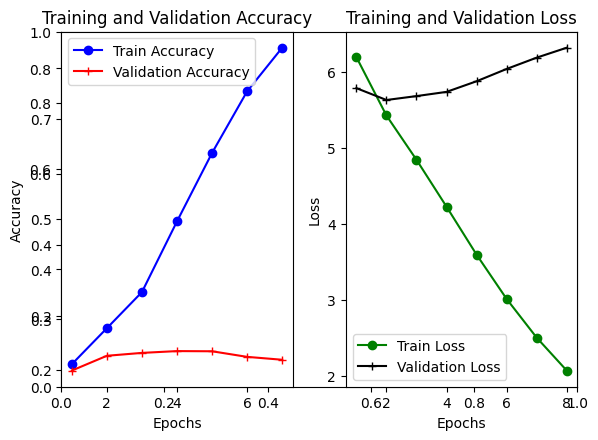

In [36]:
trainer.train()